# Predicting New York Times "Editor's Selection" comments

### Abstract

The following notebook has the goal to predict the "Editor's Selection" comments of the open articles from the [New York Times](https://www.nytimes.com/) webpage.

These are the steps to achieve this goal:
- **Import data**
- **Pre-processing features**
- **Processing comments texts**
- **Modeling and testing**
- **Discussing results**

The imported dataset contains data from January 2017 until May 2017 and from January 2018 until May 2018, related to articles and comments from NY Times. After importing, some features are pre-selected to be used in the model. The features are treated and some new features are created. The *editorsSelection* represents if the comment is an "Editor's Selection" or not, and will be the target.

The feature **commentBody** represents the comment itself. I separate it and process the text using NLP techniques. I do **Count Vectorization**, **Stemming** and **TF-IDF** to vectorize and prepare the comments for use in the model.

For classification, the **SVM** algorithm is the chosen one. It will be evaluated using three measures: **Accuracy**, **AUROC**, and **F1-Score**.

After that, the SVM will be reparameterized with **Grid Search**.

Finally, the results will be discussed and some future works will be recommended.

>Some codes and ideas were inspired by [Aashita Kesarwani Predicting NYT's pick notebook](https://www.kaggle.com/aashita/predicting-nyt-s-pick/notebook)

## Beginning

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree
from nltk.stem.snowball import SnowballStemmer
import re, string
import time
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline


%matplotlib inline

## Importing data

There are two kinds of datasets: Articles Dataset and Comments Dataset.

The Articles dataset contains more than 9000 articles and 16 features. It represents the articles headers, with information like date of publication (pubDate) and category (newDesk).

The Comments dataset contains more than 2 million comments and 34 features. This dataset contains the comment feature (commentBody) and some information about the comment, i.e. comment date of publication (approveDate). Also, it contains the target feature: **editorsSelection**.

Here is the feature relation:

|	Articles Dataset		|	Comments Dataset   |
|-----------------------|---------------------------|
|	abstract			|	approveDate				|
|	articleID			|	articleID				|
|	articleWordCount	|	articleWordCount		|
|	byline				|	commentBody				|
|	webURL				|	commentID				|
|	typeOfMaterial		|	commentSequence			|
|	source				|	commentTitle			|
|	snippet				|	commentType				|
|	sectionName			|	createDate				|
|	pubDate				|	depth					|
|	printPage			|	editorsSelection		|
|	documentType		|	inReplyTo				|
|	headline			|	newDesk					|
|	keywords			|	parentID				|
|	multimedia			|	parentUserDisplayName	|
|	newDesk				|	permID					|
|						|	picURL					|
|						|	printPage				|
|						|	recommendations			|
|						|	recommendedFlag			|
|						|	replyCount				|
|						|	reportAbuseFlag			|
|	 					|	sectionName				|
|						|	sharing					|
|						|	status					|
|						|	timespeople				|
|						|	trusted					|
|						|	typeOfMaterial			|
|						|	updateDate				|
|						|	userDisplayName			|
|						|	userID					|
|						|	userLocation			|
|						|	userTitle				|
|						|	userURL					|

For now, some features will be *excluded* from our study. Some will be removed due to their nature of non-relation with our problem.

Here are the chosen features for now:

|	Articles festures		|	Comments features	|
|---------------------------|---------------------------|
|	articleID				|	articleID				|
|	articleWordCount		|	createDate				|
|	newDesk					|	approveDate				|
|	typeOfMaterial			|	commentBody				|
|	pubDate 				|	recommendations			|
|	     					|	replyCount				|
|							|	editorsSelection		|

In [2]:
art_columns = ['articleID', 'articleWordCount', 'newDesk', 'typeOfMaterial', 'pubDate']
com_columns = ['articleID', 'createDate', 'approveDate', 'commentBody', 'recommendations', 'replyCount','editorsSelection']

df_art_jan17 = pd.read_csv('nyt-comments/ArticlesJan2017.csv', usecols=art_columns)
df_com_jan17 = pd.read_csv('nyt-comments/CommentsJan2017.csv', usecols=com_columns)
df_art_fev17 = pd.read_csv('nyt-comments/ArticlesFeb2017.csv', usecols=art_columns)
df_com_fev17 = pd.read_csv('nyt-comments/CommentsFeb2017.csv', usecols=com_columns)
df_art_mar17 = pd.read_csv('nyt-comments/ArticlesMarch2017.csv', usecols=art_columns)
df_com_mar17 = pd.read_csv('nyt-comments/CommentsMarch2017.csv', usecols=com_columns)
df_art_apr17 = pd.read_csv('nyt-comments/ArticlesApril2017.csv', usecols=art_columns)
df_com_apr17 = pd.read_csv('nyt-comments/CommentsApril2017.csv', usecols=com_columns)
df_art_may17 = pd.read_csv('nyt-comments/ArticlesMay2017.csv', usecols=art_columns)
df_com_may17 = pd.read_csv('nyt-comments/CommentsMay2017.csv', usecols=com_columns)
df_art_jan18 = pd.read_csv('nyt-comments/ArticlesJan2018.csv', usecols=art_columns)
df_com_jan18 = pd.read_csv('nyt-comments/CommentsJan2018.csv', usecols=com_columns)
df_art_fev18 = pd.read_csv('nyt-comments/ArticlesFeb2018.csv', usecols=art_columns)
df_com_fev18 = pd.read_csv('nyt-comments/CommentsFeb2018.csv', usecols=com_columns)
df_art_mar18 = pd.read_csv('nyt-comments/ArticlesMarch2018.csv', usecols=art_columns)
df_com_mar18 = pd.read_csv('nyt-comments/CommentsMarch2018.csv', usecols=com_columns)
df_art_apr18 = pd.read_csv('nyt-comments/ArticlesApril2018.csv', usecols=art_columns)
df_com_apr18 = pd.read_csv('nyt-comments/CommentsApril2018.csv', usecols=com_columns)

comments = [df_com_jan17, df_com_fev17, df_com_mar17, df_com_apr17, df_com_may17, df_com_jan18, df_com_fev18, df_com_mar18, df_com_apr18]
df_comments = pd.concat(comments)
articles = [df_art_jan17, df_art_fev17, df_art_mar17, df_art_apr17, df_art_may17, df_art_jan18, df_art_fev18, df_art_mar18, df_art_apr18]
df_articles = pd.concat(articles)

df = pd.merge(df_articles, df_comments, on='articleID', how='inner') 

## Pre-processing data

### Comments feature

Most of the comments of NY Times naturally are written in English. However, since the comments are opened for anyone, consequently we expect to find errors and unsupported characters (from different languages). For example, HTML tags and Japanese characters.

Since the nature of an "Editor's Selection" comment is to be well written and containing a relevant opinion about the subject, we must treat the inconveniences of the **commentBody** feature.

#### Removing tags and punctuation

In [3]:
def remove_tags(text):
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]',' ',text)

In [4]:
df.commentBody = df.commentBody.apply(lambda x: remove_tags(x))
df.commentBody = df.commentBody.apply(lambda x: remove_punctuation(x))

#### Removing wrong coding

In [5]:
df.commentBody = df.commentBody.apply(lambda x: str(x.encode('ascii', 'ignore')))

#### Treating english words

Using Name Entity Recognition (NER) and some English dictionary, it is possible to maintain only English words in comments.

In [6]:
#Creating Name/Entity/Place dictionary
def NER(df):
    continuous_chunk = []
    for index, row in df.iterrows():
        chunked = ne_chunk(pos_tag(word_tokenize(row['commentBody'])))
        prev = None
        current_chunk = []
        for i in chunked:
            if type(i) == Tree:
                current_chunk.append(" ".join([token for token, pos in i.leaves()]))
            elif current_chunk:
                named_entity = " ".join(current_chunk)
                if named_entity not in continuous_chunk:
                    continuous_chunk.append(named_entity)
                    current_chunk = []
                else:
                    continue
    return set(continuous_chunk)

start_time = time.time()
#Using only NER extracted from comments selected as "Editor's Selection" to reduce the dictionary
people_words = NER(df[df['editorsSelection'] == 1])
print(time.time() - start_time)

1492.6859822273254


In [7]:
#Creating English Dictionary using NLTK package
words = set(nltk.corpus.words.words() + list(nltk.corpus.wordnet.words()) + list(people_words))

In [8]:
def clean_text(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w in words or w.lower() in words or (nltk.corpus.wordnet.morphy(w.lower()) is not None and nltk.corpus.wordnet.morphy(w.lower()).lower() in words))

start_time = time.time()
df.commentBody = df.commentBody.apply(lambda x: clean_text(x)) 
print(time.time() - start_time)

326.3583779335022


### Creating feature variations

The data features won't be useful in their original conditions. It is necessary to quantify them.

In this case, it will be created two new features: **commentApprovalLength**, which represents the waiting time for the comment to be approved; and **commentPubLength**, which is the time between the article publication and the comment publication.

In [9]:
df['commentApprovalLength'] = df.apply(lambda row: (dt.datetime.fromtimestamp(int(row['approveDate'])) - dt.datetime.fromtimestamp(int(row['createDate']))).total_seconds(), axis=1)
df['commentPubLength'] = df.apply(lambda row: (dt.datetime.fromtimestamp(int(row['approveDate'])) - dt.datetime.strptime(row['pubDate'], '%Y-%m-%d %H:%M:%S')).total_seconds(), axis=1)

Also, it is now possible to count the number of words of the treated commentBody feature creating a new column called **commentWordCount**.

In [10]:
df['commentWordCount'] = df.apply(lambda row: sum(Counter(row['commentBody'].split()).values()), axis=1)

In [11]:
#Cleaning unused features
df.drop(columns=['approveDate', 'createDate', 'articleID', 'pubDate'], inplace=True)

#### Quantifying categorical features

The categorical features should be transformed into numerical features to help the classifier to not misinterpret. It will be created new columns to represent the categories in numbers (0 or 1).

In [12]:
df = pd.get_dummies(df, columns=["newDesk", "typeOfMaterial"])

#### Normalizing numerical features

The numerical features should be normalized to avoid wrong weighted classification. The MinMaxScaler() will be used for that.

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()
#Array with numerical features
np_numbers = df[['articleWordCount', 'recommendations', 'replyCount', 'commentWordCount', 'commentApprovalLength', 'commentPubLength']].values.astype(float)

#Normalizing
np_scaled = min_max_scaler.fit_transform(np_numbers)
df_normalized = pd.DataFrame(np_scaled)
#Renaming columns
df_normalized.columns = ['articleWordCount', 'recommendations', 'replyCount', 'commentWordCount', 'commentApprovalLength', 'commentPubLength']

#Joining new dataframe
cols = [i for i in df.columns.values if i not in list(['articleWordCount', 'recommendations', 'replyCount', 'commentWordCount','commentApprovalLength','commentPubLength'])]
df_normalized = df_normalized.join(df[cols])

In [14]:
#Checking how the features are now
df_normalized.head(2)

articleWordCount  recommendations  replyCount  commentWordCount  \
0          0.080429         0.000477    0.160804          0.291866   
1          0.080429         0.000286    0.160804          0.143541   

   commentApprovalLength  commentPubLength  \
0               0.001730          0.005408   
1               0.002221          0.005402   

                                         commentBody  editorsSelection  \
0  b For all you Americans out there still rejoic...                 0   
1  b Obamas policies may prove to be the least of...                 0   

   newDesk_Arts&Leisure  newDesk_Automobiles           ...             \
0                     0                    0           ...              
1                     0                    0           ...              

   typeOfMaterial_Editorial  typeOfMaterial_Interview  typeOfMaterial_Letter  \
0                         0                         0                      0   
1                         0                         0                      0   

   typeOfMaterial_News  typeOfMaterial_News Analysis  \
0                    1                             0   
1                    1                             0   

   typeOfMaterial_Obituary (Obit)  typeOfMaterial_Op-Ed  \
0                               0                     0   
1                               0                     0   

   typeOfMaterial_Question  typeOfMaterial_Review  typeOfMaterial_briefing  
0                        0                      0                        0  
1                        0                      0                        0  

[2 rows x 66 columns]

### Balancing classes

Let's check how the targed feature **editorsSelection** is balanced in the sample.

1.9107573251608228


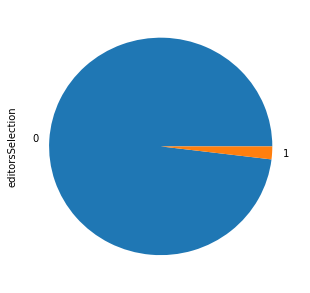

In [15]:
pd.value_counts(df_normalized['editorsSelection']).plot.pie(figsize = (5,5))
print((float(pd.value_counts(df_normalized['editorsSelection'])[1])/float(pd.value_counts(df_normalized['editorsSelection']).sum())) * 100)

It is notable the unbalanced dataset. The editorsSelection class = 1 represents **1.91%** of the entire dataset. To work with this class, it is necessary to downsample the editorsSelection class = 0.

25.0


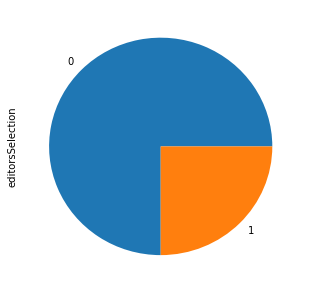

In [27]:
'''
Returns the balanced class using the percentage that is needed to maintain in the class with less occurrence.
For example, if we need the class 1 (minority) to represents 30% of the entire dataset, percent = 0.3. 
The class 0 (majority) will have samples removed randomly until it represents 70% of the entire dataset.
'''
def downSampling(sample, col_class, percent):
    #Finding the majority and minority class
    counts = sample[col_class].value_counts().to_dict()
    max_label = max(counts.keys(), key=(lambda k: counts[k]))
    min_label = min(counts.keys(), key=(lambda k: counts[k]))
    #Separating class samples
    sample_max = sample[sample[col_class] == max_label]
    sample_min = sample[sample[col_class] == min_label]
    #Finding the actual ratio between classes
    actual_ratio = float(min(counts.values()))/float(sum(counts.values()))
    if(actual_ratio >= percent):
        return sample
    #Calculating the number of necessary samples to be excluded
    desired_samples = int(float(min(counts.values()) - (percent * min(counts.values()))) / float(percent))
    #Resampling dataset
    sample_max_downsampled = resample(sample_max, replace=False, n_samples=desired_samples, random_state=100)
    #Combining samples
    sample_downsampled = pd.concat([sample_max_downsampled, sample_min])
    return sample_downsampled

#It was chosen the 1:4 (25%) ratio for downsampling
df_normalized_balanced = downSampling(df_normalized, 'editorsSelection', 0.25)
pd.value_counts(df_normalized_balanced['editorsSelection']).plot.pie(figsize = (5,5))
print((float(pd.value_counts(df_normalized_balanced['editorsSelection'])[1])/float(pd.value_counts(df_normalized_balanced['editorsSelection']).sum())) * 100)

>It was chosen the value of 25% to compare to [Aashita Kesarwani Predicting NYT's pick notebook](https://www.kaggle.com/aashita/predicting-nyt-s-pick/notebook)

Now the editorsSelection class = 1 is balanced to represents **25%** of the dataset.

### NLP - Working with comments

Now we use NLP techniques to transform the comments text into a feature vector, to use later in classification.

#### Count Vectorizer e Stemming

We will use Count Vectorizer to transform text into a count vector with the words frequency. Also, we use Stemming to reduce words to the root form.

In [28]:
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english', decode_error='ignore')
counts = stemmed_count_vect.fit_transform(df_normalized_balanced['commentBody'].values.astype('U'))

print(counts.shape)

(165944, 31995)


#### TF-IDF
To reduce the weight of the counting, it is needed to normalize frequency with TF-IDF.

In [29]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(counts)

print(tfidf.shape)

(165944, 31995)


**What we have so far**: cleaned and treated features, extra features and comment texts vectorized.

Now we build our model.

### Modeling and evaluating

Firstly, let's separate the target feature from the rest.

In [30]:
y = df_normalized_balanced[['editorsSelection']]
X = df_normalized_balanced.drop(['editorsSelection', 'commentBody'], axis=1)

The classification algorithm chosen is SVM with linear kernel (**SGDClassifier**).

The chosen metrics to measure the model performance will be **Acurracy**, **AUROC**, and **F1-Score**.

For training and validation, the dataset will be split into three parts: **80%/20%**, **70%/30%** e **60%/40%** (Training/Testing). After that, we calculate the mean of the metrics.

In [31]:
def get_metrics(y_test, predicted):
    fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)
    roc = auc(fpr, tpr)
    f1 = f1_score(y_test, predicted, average='binary')
    ac = np.mean(predicted == y_test)
    return roc, f1, ac

In [33]:
def train_predict(clf, X_train, y_train, X_test):
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    return predicted

def results_train_test(clf, X, y):

    X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X, y, test_size=0.2, random_state=100)
    X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=100)
    X_train_60, X_test_40, y_train_60, y_test_40 = train_test_split(X, y, test_size=0.4, random_state=100)

    pred_20 = train_predict(clf, X_train_80, y_train_80, X_test_20)
    pred_30 = train_predict(clf, X_train_70, y_train_70, X_test_30)
    pred_40 = train_predict(clf, X_train_60, y_train_60, X_test_40)

    roc20, f120, acc20 = get_metrics(y_test_20, pred_20)
    roc30, f130, acc30 = get_metrics(y_test_30, pred_30)
    roc40, f140, acc40 = get_metrics(y_test_40, pred_40)
    mean_roc = (roc20 + roc30 + roc40) / 3
    mean_acc = (acc20 + acc30 + acc40) / 3
    mean_f1 = (f120 + f130 + f140) / 3
    print('Mean Accuracy: {0:0.2f}'.format(mean_acc))
    print('Mean AUROC: {0:0.2f}'.format(mean_roc))
    print('Mean F1-Score: {0:0.2f}'.format(mean_f1))

We now create the full feature vector, joining the TF-IDF output and the others features.

>Hstack is used to avoid memory overflow when adding the TF-IDF features to dataframe. Also, we will work with sparse matrices from now on.

In [38]:
cols = [i for i in df_normalized_balanced.columns.values if i not in list(['editorsSelection','commentBody', 'articleWordCount'])]

features_vector = hstack((tfidf,np.array(X['articleWordCount'])[:,None]))
for i in cols:
    features_vector = hstack((features_vector,np.array(X[i])[:,None]))
print(features_vector.shape)

(165944, 32059)


We can now test the **SVM**.

In [42]:
#Creating SVM class with arbitrary parameters
svm_clf = linear_model.SGDClassifier(loss='hinge', max_iter=5, random_state=100)

In [43]:
results_train_test(svm_clf, features_vector, y.values.ravel())

Mean Accuracy: 0.80
Mean AUROC: 0.61
Mean F1-Score: 0.36


To optimize the SVM performance, we are going to use **Grid Search**.

#### Grid Search

To improve the SVM parameterization, we put some parameters to GridSearch finds the optimal configuration.

In [97]:
pipeline = Pipeline([
    ('clf', SGDClassifier())
])

parameters = {
    'clf__alpha': (0.0001, 0.00001, 0.000001, 0.0000001),
    'clf__epsilon': (0.1, 0.01, 0.001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (5, 10, 15, 20),
    'clf__class_weight': ('balanced', {0:.1, 1:.2}, {0:.1, 1:.3}, {0:.1, 1:.4})
}
grid = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring = 'f1')

In [98]:
#For GridSearch we will use the training/testing ratio of 70%/30%
X_train, X_test, y_train, y_test = train_test_split(features_vector, y.values.ravel(), test_size=0.3, random_state=100)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__alpha': (0.0001, 1e-05, 1e-06, 1e-07), 'clf__epsilon': (0.1, 0.01, 0.001), 'clf__penalty': ('l2', 'elasticnet'), 'clf__max_iter': (5, 10, 15, 20), 'clf__class_weight': ('balanced', {0: 0.1, 1: 0.2}, {0: 0.1, 1: 0.3}, {0: 0.1, 1: 0.4})},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [99]:
print("Best Parameters:")
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best Parameters:
	clf__alpha: 1e-06
	clf__class_weight: {0: 0.1, 1: 0.2}
	clf__epsilon: 0.01
	clf__max_iter: 20
	clf__penalty: 'elasticnet'


With the best parameters, it is possible to improve SVM performance.

In [100]:
optimal_svm_clf = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet', alpha=1e-06, epsilon=0.01, max_iter=20, class_weight={0: 0.1, 1: 0.2}, random_state=100)
results_train_test(optimal_svm_clf, features_vector, y.values.ravel())

Mean Accuracy: 0.85
Mean AUROC: 0.80
Mean F1-Score: 0.70


## Discussing results

#### SVM (first results)

|	 -		|	SVM (Raw)	|
|---------------------------|---------------------------|
|	Mean Accuracy				|	0.80				|
| Mean AUROC | 0.61|
| Mean F1-Score | |

The first results show us how hard is to the classifier to infer the class = 1 ("Editor's Selection") due to the class balance. Even reducing the unbalanced class from our first dataset, it is still hard to classify with not much knowledge of the parameters.

#### SVM (Grid Search)
| - |	SVM (Grid Search)			|
|-|-----------------------|
| Mean Accuracy			| 0.85 |
| Mean AUROC  | 0.80 |
| Mean F1-Score			| 0.70 |

The results now are way better. Improving the f1-score in Grid Search helped the SVM to penalise misclassification of the class = 1. 


#### Future work suggestions

There are some ways to improve the model.

- The ignored features from the beginning may be used to achieve new insights into the dataset.
- Feature selection may help to improve the model generalization and avoid overfitting. Maybe XGBoost could be a good option to reduce dimensionality.
- SVM may be improved using another kernel. Linear kernel is good in performance, but there are others kernels can generalize better.